In [1]:
import csv
import random
import pandas as pd
from tqdm import tqdm
from itertools import islice
from vllm import LLM, SamplingParams
from transformers import AutoTokenizer

SEED = 1337
random.seed(SEED)

INFO 03-14 17:45:28 __init__.py:190] Automatically detected platform cuda.


In [2]:
df = pd.read_csv("../../data/data_raw/nyt-articles-2020.csv")
df.head()

,newsdesk,section,subsection,material,headline,abstract,keywords,word_count,pub_date,n_comments,uniqueID
0,Editorial,Opinion,NaN,Editorial,Protect Veterans From Fraud,Congress could do much more to protect America...,"['Veterans', 'For-Profit Schools', 'Financial ...",680,2020-01-01 00:18:54+00:00,186,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...
1,Games,Crosswords & Games,NaN,News,‘It’s Green and Slimy’,Christina Iverson and Jeff Chen ring in the Ne...,['Crossword Puzzles'],931,2020-01-01 03:00:10+00:00,257,nyt://article/9edddb54-0aa3-5835-a833-d311a76f...
2,Science,Science,NaN,News,Meteor Showers in 2020 That Will Light Up Nigh...,"All year long, Earth passes through streams of...","['Meteors and Meteorites', 'Space and Astronom...",1057,2020-01-01 05:00:08+00:00,6,nyt://article/04bc90f0-b20b-511c-b5bb-3ce13194...
3,Science,Science,NaN,Interactive Feature,Sync your calendar with the solar system,"Never miss an eclipse, a meteor shower, a rock...","['Space and Astronomy', 'Moon', 'Eclipses', 'S...",0,2020-01-01 05:00:12+00:00,2,nyt://interactive/5b58d876-9351-50af-9b41-a312...
4,Science,Science,NaN,News,"Rocket Launches, Trips to Mars and More 2020 S...",A year full of highs and lows in space just en...,"['Space and Astronomy', 'Private Spaceflight',...",1156,2020-01-01 05:02:38+00:00,25,nyt://article/bd8647b3-8ec6-50aa-95cf-2b81ed12...


In [3]:
len(df)

16787

In [4]:
df.isna().sum()

newsdesk          0
section           0
subsection    11094
material          0
headline          0
abstract          3
keywords          1
word_count        0
pub_date          0
n_comments        0
uniqueID          0
dtype: int64

In [5]:
df.dropna(subset=["abstract"], inplace=True)

In [6]:
df["length_abstract"] = df["abstract"].str.len()
df["length_headline"] = df["headline"].str.len()

In [7]:
df = df[(df["length_abstract"] >= 50) & (df["length_headline"] >= 10)]

In [8]:
df.duplicated(subset="abstract").sum()

np.int64(196)

In [9]:
df.drop_duplicates(subset="abstract", inplace=True)

In [10]:
len(df)

15813

In [11]:
def batchify(iterable, batch_size):
    """Splits an iterable into smaller batches."""
    iterable = iter(iterable)
    while batch := list(islice(iterable, batch_size)):
        yield batch

def save_to_csv(path, prompts, responses, temperature, top_p, top_k):
    """Saves prompts, responses and sampling parameters to a CSV file."""
    with open(path, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        for prompt, response in zip(prompts, responses):
            writer.writerow([prompt, response, temperature, top_p, top_k])

def generate_responses(model, prompts, sampling_params):
    """Generate a batch of outputs using vLLM with customizable sampling parameters."""
    outputs = model.chat(prompts, sampling_params=sampling_params, use_tqdm=False)
    
    return [sample.outputs[0].text.replace('"', '') for sample in outputs]

In [12]:
BASE_PROMPT = [{"role": "system", "content": "You are a helpful asistant for writing article abstracts. Based on provided headline and a list of keywords generate abstract of an article. MAKE SURE TO REPLAY ONLY WITH THE ABSTRACT."},
                {"role": "user", "content": "Headline: \n {headline} \n  Keywords: \n {keywords}."},
                {"role": "assistant", "content": "Abstract: \n"}]

In [13]:
prompts = []
for headline, keywords in df[["headline", "keywords"]].values:
    try:
        kw = ", ".join(eval(keywords))
    except:
        kw = "None"
    prompt = [
        BASE_PROMPT[0], # The system message
        {"role": "user", "content": BASE_PROMPT[1]["content"].format(headline=headline, keywords=kw)},  # Formatted user message
        BASE_PROMPT[2]  # The assistant message
    ]
    prompts.append(prompt)

In [14]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B-Instruct")

In [15]:
lens = []
batch_size = 128
for prompts_batch in tqdm(batchify(prompts, batch_size), total=len(prompts) // batch_size):
    tokens = tokenizer.apply_chat_template(prompts_batch)
    lens.extend([len(token) for token in tokens])

  0%|          | 0/123 [00:00<?, ?it/s]

124it [00:04, 27.00it/s]                         


In [ ]:
too_large = [i for i, l in enumerate(lens) if l > 16_384]
too_large

[]

In [17]:
df.drop(columns=["newsdesk", "section", "subsection", "material", "headline", "keywords", "word_count", "pub_date", "n_comments", "uniqueID", "length_abstract", "length_headline"], inplace=True)
df.to_csv("../../data/data_human/nyt_articles.csv", index=False)

In [19]:
from nltk.tokenize import word_tokenize, sent_tokenize
df['word_count'] = df['abstract'].apply(lambda x: len(word_tokenize(x)))
df['sentence_count'] = df['abstract'].apply(lambda x: len(sent_tokenize(x)))

In [20]:
import numpy as np
import matplotlib.ticker as ticker

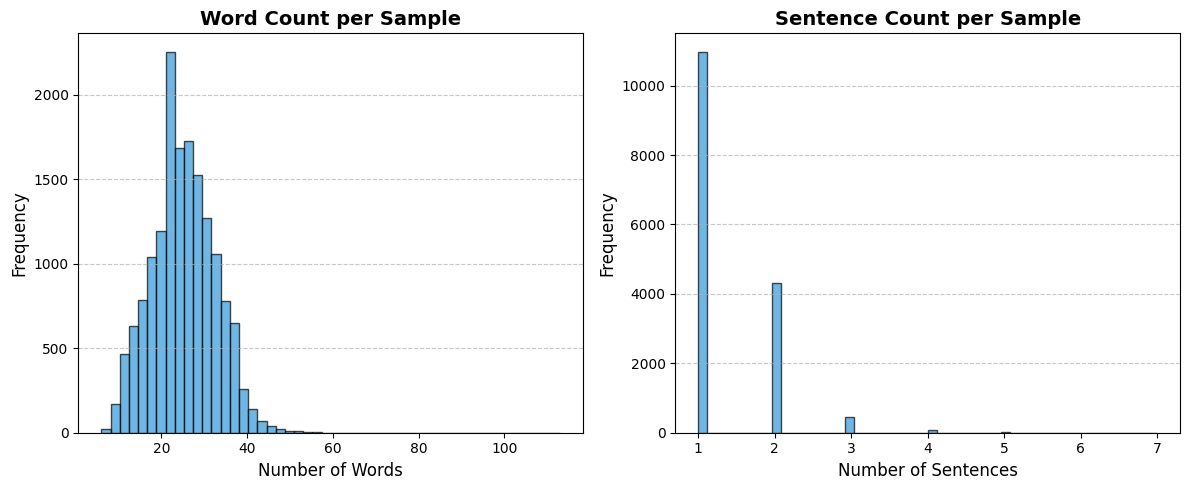

In [21]:
import matplotlib.pyplot as plt
# word_bins = np.logspace(np.log10(1), np.log10(df['word_count'].max()), 50)
# sentence_bins = np.logspace(np.log10(1), np.log10(df['sentence_count'].max()), 50)

# Plot histograms using Matplotlib
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=100)

# Word count histogram
axes[0].hist(df['word_count'], bins=50, color='#3498db', edgecolor='black', alpha=0.7)
# axes[0].set_xscale('log')  # Logarithmic scale for x-axis
axes[0].set_title('Word Count per Sample', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Words', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].tick_params(axis='both', which='major', labelsize=10)
axes[0].tick_params(axis='both', which='minor', labelsize=8)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Sentence count histogram
axes[1].hist(df['sentence_count'], bins=50, color='#3498db', edgecolor='black', alpha=0.7)
# axes[1].set_xscale('log')  # Logarithmic scale for x-axis
axes[1].set_title('Sentence Count per Sample', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Sentences', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].tick_params(axis='both', which='major', labelsize=10)
axes[1].tick_params(axis='both', which='minor', labelsize=8)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [35]:
sampling_params = [
    SamplingParams(temperature=0.0, top_p=1.0, top_k=-1, max_tokens=40_000, seed=SEED),  # Pure Greedy (fully deterministic)
    SamplingParams(temperature=0.2, top_p=1.0, top_k=-1, max_tokens=40_000, seed=SEED),  # Highly Deterministic
    SamplingParams(temperature=0.5, top_p=0.95, top_k=100, max_tokens=40_000, seed=SEED), # Mildly Deterministic but Flexible
    SamplingParams(temperature=0.7, top_p=0.9, top_k=50, max_tokens=40_000, seed=SEED),  # Balanced and Natural
    SamplingParams(temperature=0.9, top_p=0.8, top_k=40, max_tokens=40_000, seed=SEED),  # Slightly More Diverse but Coherent
    SamplingParams(temperature=1.0, top_p=0.95, top_k=30, max_tokens=40_000, seed=SEED), # Default Creative Mode
    SamplingParams(temperature=1.2, top_p=0.7, top_k=20, max_tokens=40_000, seed=SEED),  # Highly Creative
]

In [36]:
llms = ["meta-llama/Llama-3.2-1B-Instruct"]
batch_size = 8
base_path = "../../data/data_ai/nyt_articles/nyt-articles_"

In [ ]:
for llm in llms:
    model = LLM(model=llm, dtype="half", max_model_len = 10_000)
    csv_path = f"{base_path}{llm.split('/')[-1]}.csv"


    # init csv file
    with open(csv_path, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["prompt", "response", "temperature", "top_p", "top_k"])

    cnt = 0
    for prompts_batch in tqdm(batchify(prompts, batch_size), total=len(prompts) // batch_size):
        params = random.choice(sampling_params)
        responses = generate_responses(model, prompts_batch, params)
        save_to_csv(csv_path, prompts_batch, responses, params.temperature, params.top_p, params.top_k)
        cnt += 1
        if cnt > 2:
            break

WARNING 02-15 00:34:28 config.py:2386] Casting torch.bfloat16 to torch.float16.
INFO 02-15 00:34:39 config.py:542] This model supports multiple tasks: {'generate', 'classify', 'score', 'embed', 'reward'}. Defaulting to 'generate'.
INFO 02-15 00:34:39 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.2) with config: model='meta-llama/Llama-3.2-1B-Instruct', speculative_config=None, tokenizer='meta-llama/Llama-3.2-1B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=10000, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, c

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 02-15 00:34:50 model_runner.py:1115] Loading model weights took 2.3185 GB
INFO 02-15 00:34:52 worker.py:267] Memory profiling takes 2.16 seconds
INFO 02-15 00:34:52 worker.py:267] the current vLLM instance can use total_gpu_memory (6.00GiB) x gpu_memory_utilization (0.90) = 5.40GiB
INFO 02-15 00:34:52 worker.py:267] model weights take 2.32GiB; non_torch_memory takes 0.04GiB; PyTorch activation peak memory takes 1.21GiB; the rest of the memory reserved for KV Cache is 1.84GiB.
INFO 02-15 00:34:52 executor_base.py:110] # CUDA blocks: 3761, # CPU blocks: 8192
INFO 02-15 00:34:52 executor_base.py:115] Maximum concurrency for 10000 tokens per request: 6.02x
INFO 02-15 00:34:58 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utiliz

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:25<00:00,  1.37it/s]

INFO 02-15 00:35:23 model_runner.py:1562] Graph capturing finished in 26 secs, took 0.12 GiB
INFO 02-15 00:35:23 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 33.89 seconds



  0%|          | 0/2098 [00:00<?, ?it/s]

INFO 02-15 00:35:24 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.


  0%|          | 2/2098 [00:13<3:54:58,  6.73s/it]


In [ ]:
df = pd.read_csv("../../data/data_ai/nyt_articles/nyt-articles_Llama-3.2-1B-Instruct.csv")
df.head()

,prompt,response,temperature,top_p,top_k
0,"[{'role': 'system', 'content': 'You are a help...",The increasing trend of for-profit schools lur...,1.2,0.7,20
1,"[{'role': 'system', 'content': 'You are a help...",Unraveling the Fascination with Crossword Puzz...,1.2,0.7,20
2,"[{'role': 'system', 'content': 'You are a help...","In 2020, a spectacular meteor shower swept acr...",1.2,0.7,20
3,"[{'role': 'system', 'content': 'You are a help...",As the universe continues to fascinate us with...,1.2,0.7,20
4,"[{'role': 'system', 'content': 'You are a help...","In 2020, a pivotal year for space exploration,...",1.2,0.7,20
